In [1]:
import torch.nn.functional as F
from torchvision import transforms 
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.optim import Adam
from torch import nn
from datasets import load_dataset
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

### Part 1. On attention [2 points]

Answer each question in max. 3 lines. Points will be subtracted for long answers so be short and precise. Add your explanations in the below box - NO added handwritten images, write in latex!

1. [0.5 point] You are given an input $X=[x_1,...,x_L]$ (e.g. a sentence of tokenised words). Your goal is to predict the next token $x_i$ conditional on $x_{1},...,x_{i}$. In other words, the $i$-th position can only be influenced by a position $j$ if and only if $j \leq i$, namely a position cannot be influenced by the subsequent positions.
    a. What would be the problem when passing $X$ through attention? Explain using the computations that attention performs, e.g. you can write out the matrix multiplication. 
    b. How could you ensure that the prediction for position $i$ depends solely on positions $j\leq i$? Hint: what in the attention computation should be masked & in what way? 
2. [0.5 point] Let's consider multi-head attention. How does multi-head attention change the computations inside the softmax (the $QK^T$ term) and the product with $V$ and why could this be beneficial to learning? 
3. [0.5 point] Remember that standard attention is given by 
\begin{align}
Q = XW^Q, \; K=XW^K, \; V=XW^V, \;\; \textnormal{with} A(X) = softmax\left(\frac{QK^T}{\sqrt{D}}\right)V
\end{align}
for a sequence $X\in\mathbb{R}^{L\times D}$ with $L$ the sequence length. 
What is the memory and computational cost of attention in terms of the sequence length and where does this come from? 
4. [0.5 point] A big focus these days is on making attention more computationally efficient. The $i$-th row (as a vector) of attention can be rewritten as, 
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L sim(Q_i,K_j)V_j}{\sum_{j=1}^L sim(Q_i,K_j)},
\end{align}
with $sim(q,k)=exp(q^Tk/\sqrt{D})$.
Linear attention would be given by, 
\begin{align}
A(X)_i = \frac{\sum_{j=1}^L \phi(Q_i)^T\phi(K_j)V_j}{\sum_{j=1}^L\phi(Q_i)^T\phi(K_j)}. 
\end{align} 
Explain the relation between regular attentin and linear attention (i.e. what kind of similarity function does linear attention assume and how is the approximation made?) & how the above expression can be rewritten and use this to explain why linear attention computation can be done more efficiently compared to standard attention. 

Fill in your answers below. 

1. 

2. 

3. 

4. 

### Part 2. On diffusion models [12 points]

We will be implementing a diffusion model. We will follow mostly the setup as done here: https://arxiv.org/pdf/2006.11239.pdf so please refer to this work for more details if needed. 

Your goal will be to implement the code for the diffusion model, find the right configuration to train the model, achieve good accuracy and efficiency and finally interpret how the model learns. You will be marked on clean code, concise answers and good results. 

We will be working with the FashionMNIST dataset. You can load the data using the below code. 

In [2]:
IMG_SIZE = 32
BATCH_SIZE = 128

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
channels = 1

# define image transformations (e.g. using torchvision)
transform = Compose([
            Resize((IMG_SIZE,IMG_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(), # converts to [0,1],
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

dataloader = DataLoader(transformed_dataset['train'], batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
device = "cuda" if torch.cuda.is_available() else "cpu"


The following helper functions will be useful. In particular, whenever we input a vector (list) of values, this will help to select the right time t output. We will use this in the sampling loops. 

In [3]:
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])


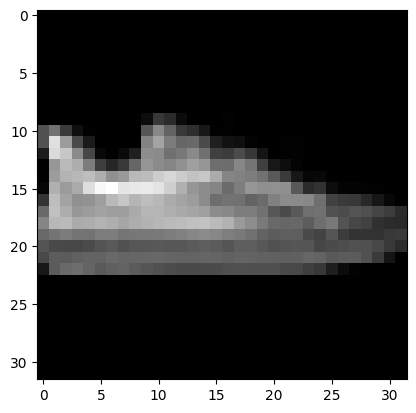

In [4]:
a = next(iter(dataloader))["pixel_values"][0,0,:,:]
plt.imshow(a,cmap = "gray")
print(a)

##### 1. The noising process [2 points]

[1.5 pts] Our first step will be to implement the forward process that adds noise to an image. 

We will be adding noise according to a linear schedule, i.e. the noises $\beta_t$, $t=1,...,T$ will come from an equally spaced vector. Implement the `linear_beta_schedule` function. Remember $\alpha_t = 1-\beta_t$ and $\bar \alpha_t = \prod_{s=1}^t \alpha_s$. 

Remember that we have the closed-form solutions for the image at time $t$. Use those in the implementation of `forward_diffusion_sample` instead of a for loop over each noising step. This means you will need to implement `sqrt_one_minus_alphas_cumprod` which represents $\sqrt{1-\bar\alpha_t}$ and `sqrt_alphas_cumprod` which represents $\sqrt{\bar\alpha_t}$. 

Test the function on an image from the dataset using the given code below. 

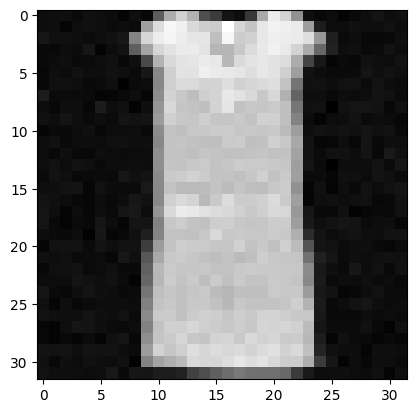

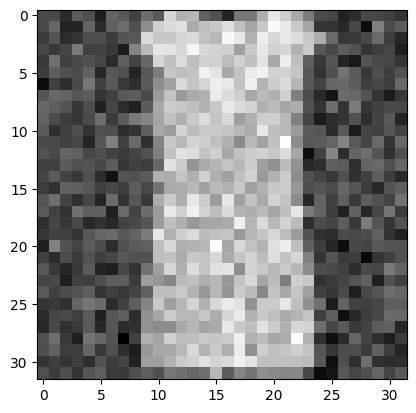

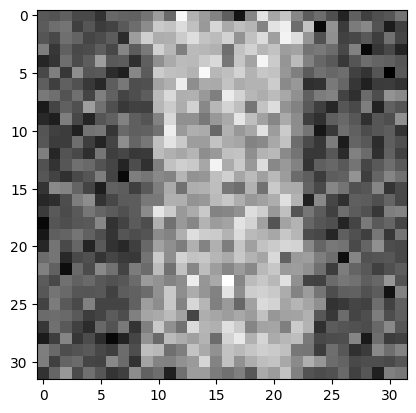

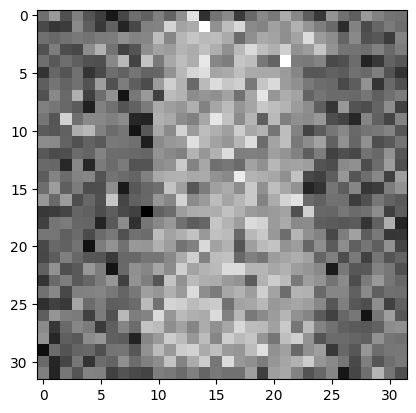

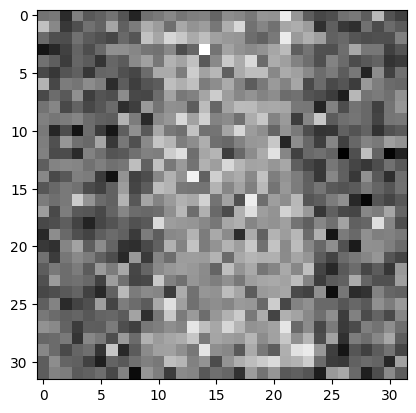

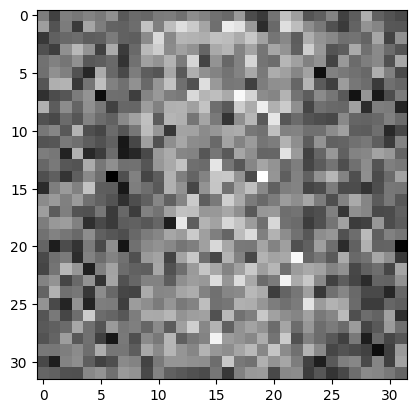

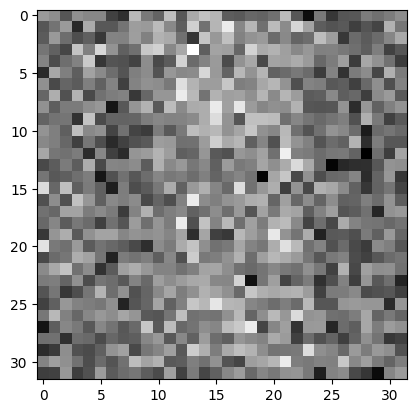

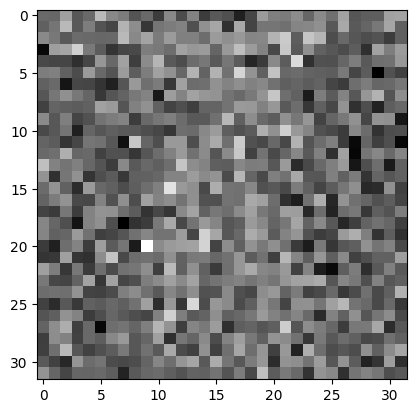

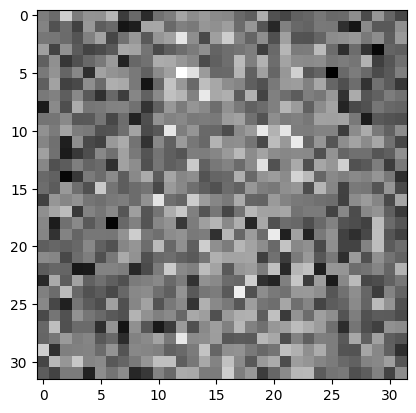

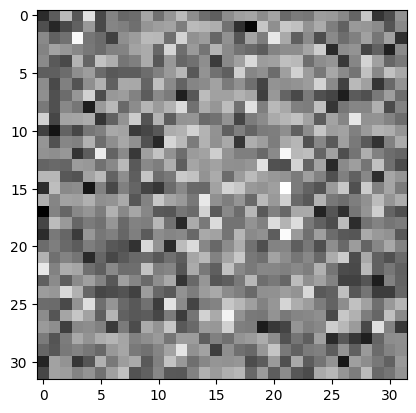

In [4]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    '''
    output a vector of size timesteps that is equally spaced between start and end; this will be the noise that is added in each time step. 
    '''
    return torch.linspace(start,end,steps = timesteps)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    Hint: use the get_index_from_list function to select the right values at time t. 
    """ 
    #noise:
    noise = torch.randn_like(x_0)
    # we have closed form solution due to markov process
    x = get_index_from_list(sqrt_alphas_cumprod,t,x_0.shape) * x_0.to(device) + get_index_from_list(sqrt_one_minus_alphas_cumprod,t,x_0.shape) * noise.to(device)
    return x, noise

# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T, start = 0.001)

# Pre-calculate different terms for closed form
# ADD HERE THE COMPUTATIONS NEEDED for sqrt_alphas_cumprod and sqrt_one_minus_alphas_cumprod


def get_alphas(betas):
    alphas = 1 - betas
    cumprod_alphas = torch.cumprod(alphas,0)
    sqrt_alphas_cumprod = torch.sqrt(cumprod_alphas)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - cumprod_alphas)
    return sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod 


sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod = get_alphas(betas)

# Simulate forward diffusion
batch = next(iter(dataloader))["pixel_values"]
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    img,noise =  forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    plt.imshow(img.reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
    plt.show()

[0.5 pt] Play around with the noise (compare two different beta schedules), present results for the two settings and discuss (in max. 3 lines) how the hyperparameters change the forward sampling. 

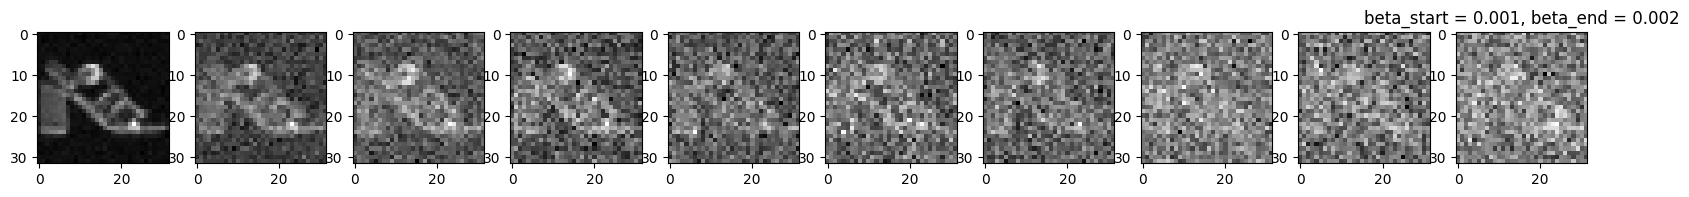

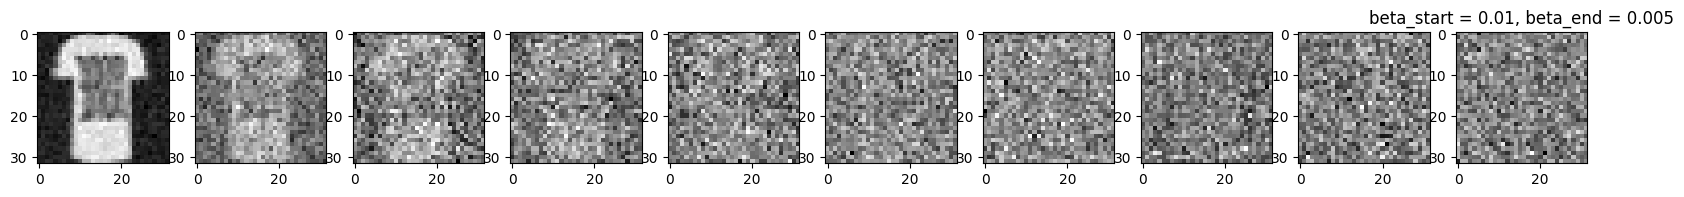

In [5]:
# Visualising noise:

betas_test1 = linear_beta_schedule(timesteps=T, start = 0.001, end =0.002)

sqrt_alphas_cumprod_test1, sqrt_one_minus_alphas_cumprod_test1 = get_alphas(betas_test1)

# Simulate forward diffusion, and show 10 states
batch = next(iter(dataloader))["pixel_values"]
num_images = 10
stepsize = int(T/num_images)

fig, axs = plt.subplots(nrows=1, ncols = 10)
fig.set_figwidth(20)
for i, idx in enumerate(range(0, T, stepsize)):
    t = torch.Tensor([idx]).type(torch.int64)
    img,noise =  forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod_test1, sqrt_one_minus_alphas_cumprod_test1)
    axs[i].imshow(img.reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
plt.title("beta_start = 0.001, beta_end = 0.002")
plt.show()

#Now repeat for different schedule

betas_test2 = linear_beta_schedule(timesteps=T, start = 0.01, end = 0.05)

sqrt_alphas_cumprod_test2, sqrt_one_minus_alphas_cumprod_test2 = get_alphas(betas_test2)

# Simulate forward diffusion, and show 10 images
batch = next(iter(dataloader))["pixel_values"]
num_images = 10
stepsize = int(T/num_images)

fig, axs = plt.subplots(nrows=1, ncols = 10)
fig.set_figwidth(20)
for i, idx in enumerate(range(0, T, stepsize)):
    t = torch.Tensor([idx]).type(torch.int64)
    img,noise =  forward_diffusion_sample(batch[0,:,:,:], t, sqrt_alphas_cumprod_test2, sqrt_one_minus_alphas_cumprod_test2)
    axs[i].imshow(img.reshape(IMG_SIZE, IMG_SIZE), cmap="gray")
plt.title("beta_start = 0.01, beta_end = 0.005")
plt.show()



Since the images are equally spread over the beta range, the lower we set the start, the less distorted the starting image is, since less noise is added. The lower we set the end beta, the less distorted the final image is, this is seen in the first plot above. In the second plot, we increase the start and end values, and give a bigger range. This means the first image is more distorted than the other plot, and so is the final image. Also, the rate at which they distort is greater with the greater range, since the noise added at each iteration is larger due to stepping through the larger range in the same number of steps.

##### 2. The model for the noise [4 points]

We use a simple form of a UNet to predict the noise in the image. The input into the neural network will be a noisy image and the ouput from the model will be the noise in the image. It is important to also pass in the timestep into the neural network (so the model knows at which time we want to denoise the image) and we do this by passing it through a sinusoidal position embedding. 

[0.5pt] Write code for the Sinusoidal Position Embedding. This should output a matrix $PE$ of size `[timesteps, dimension]` with elements:

\begin{align}
&PE_{pos,2i} = \sin\left(\frac{pos}{10000^{2i/dim}}\right),\\
&PE_{pos,2i+1} = \cos\left(\frac{pos}{10000^{2i/dim}}\right),
\end{align}
where `pos` refers to the time position and `i` refers to the dimension position and `dim` the total dimension we are working with. 

Use however the following identity to implement: 
\begin{align}
\frac{pos}{10000^{2i/dim}} = \exp\left(\log(pos) - \frac{2i}{dim}\log(10000)\right).
\end{align}

In [6]:
'''class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        #assuming even dimension
    def forward(self, time):
        wavelength = 10000
        timesteps = time.shape[0]
        #timesteps = np.arange(time)
        idx = np.arange(self.dim)
        I, pos = np.meshgrid(idx, time)
        q = np.exp(np.log(pos) - I / self.dim * np.log(wavelength))
        #now pe
        pe_even = np.sin(q)
        pe_odd = np.cos(q)
        #put them in the positions
        pe = np.zeros((timesteps,self.dim))
        #only select odd and even in the position dimension
        pe[:,::2] = pe_even[:,::2]
        pe[:,1::2] = pe_odd[:,::2]
        pe = torch.tensor([pe],dtype = torch.float32)
        return pe.squeeze()'''
    
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

[0.5pt] Visualise the positional embeddings with arbitary time and dimension and discuss what position embeddings do (why do we add them, why this particular embedding structure) in max. 3 lines. 

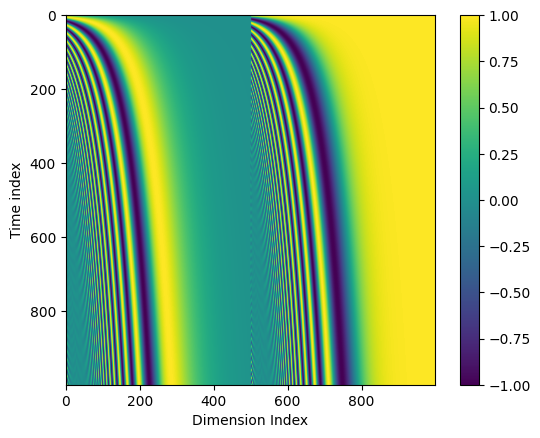

In [7]:
# Write here the code to visualise the positional embedding
spe = SinusoidalPositionEmbeddings(1000)
time = torch.linspace(0,300,steps = 1000)
#time = np.random.randint(0,300,1000)
a = spe(time)
plt.imshow(a)
plt.colorbar()
plt.xlabel("Dimension Index")
plt.ylabel("Time index")
plt.show()

We need the positional encodings since the relative positions of the pixels in the image are important.

Below is the code for a Block, that will make up the final UNet. 

[0.5pt] Fill in the missing parts. 

Remember that in the UNet architecture, we have a downsampling phase and an upsampling phase. Depending on which phase we are in, we need to make use of the up or down-sample operations. 

[0.5pt] Add here an explanation as to what the block does including the up and downsample operations in maximum 3 lines:

Explanation of a Block: YOUR ANSWER GOES HERE

In [8]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        '''
        in_ch refers to the number of channels in the input to the operation and out_ch how many should be in the output
        '''
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
    def forward(self, x, t):
        #time
        t = self.relu(self.time_mlp(t))
        #first convolution
        h = self.bnorm1(self.relu(self.conv1(x)))
        #add time
        h = h + t[...,None][...,None]
        #next conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        #up or down
        h = self.transform(h)
        return h


In [9]:
a = [1,2,3,4,5]
a[-2:]

[4, 5]

[1.5pt] Use the above code to fill in the code for the UNet below. 

In [22]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64,128,256,512,1024) # These are the channels that we want to obtain in the downsampling stage
        up_channels = (1024,512,256,128,64) # These are the channels that we want to obtain in the upsampling stage;
        out_dim = 1
        time_emb_dim = T
        self.relu = nn.ReLU()
        # Time embedding consists of a Sinusoidal embedding, a linear map that maintains the dimensions and a rectified linear unit activation. 
        self.time_embedding = SinusoidalPositionEmbeddings(time_emb_dim)
        self.time_lin = nn.Linear(time_emb_dim,time_emb_dim)
        # Initial projection included in the down channels
        self.initial_proj = nn.Conv2d(image_channels, down_channels[0],3,padding = 1)
        # Downsample: use the Blocks given above to define down_channels number of downsampling operations. These operations should cha
        self.down = nn.ModuleList([Block(down_channels[i], down_channels[i+1],time_emb_dim=time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.up= nn.ModuleList([Block(up_channels[i], up_channels[i+1],time_emb_dim=time_emb_dim, up = True) for i in range(len(up_channels)-1)])
        # Final output: 
        self.finalconv = nn.Conv2d(up_channels[-1],out_dim,kernel_size=1)
        #intermediate block
    def forward(self, x, timestep):
        #setup vector for residuals
        resid = []
        # Embedd time
        t = self.relu(self.time_lin(self.time_embedding(timestep)))
        h = x
        #initial
        h = self.initial_proj(h)
        #downsampling
        for block in self.down:
            h = block(h,t)
            resid.append(h)
        #upsampling
        
        #reverse order of residuals
        resid = resid[::-1]
        for i, block in enumerate(self.up):
            h = torch.cat((h,resid[i]),dim = 1)
            print(h.shape)
            h = block(h,t)

        #pass through final layer
        h = self.finalconv(h)
        return h
            
        

In [23]:
model = SimpleUnet()

In [24]:
a = torch.randn((1,1,32,32))
t = torch.tensor([50])
model(a,t)

torch.Size([1, 2048, 2, 2])
torch.Size([1, 1024, 4, 4])
torch.Size([1, 512, 8, 8])
torch.Size([1, 256, 16, 16])


tensor([[[[-0.1000,  0.0027, -0.1166,  ...,  0.0633, -0.0625, -0.1212],
          [ 0.0067, -0.0182,  0.0400,  ..., -0.1012,  0.0092,  0.0672],
          [-0.0363,  0.1240,  0.1391,  ...,  0.2176,  0.0118,  0.0019],
          ...,
          [-0.0907,  0.0314, -0.2190,  ..., -0.1314, -0.0171,  0.0464],
          [-0.0007, -0.0306, -0.0070,  ..., -0.1239, -0.2709,  0.0755],
          [ 0.0578, -0.1735, -0.0131,  ..., -0.0315,  0.1206, -0.0856]]]],
       grad_fn=<ConvolutionBackward0>)

[0.5pt] Finally, define a loss function. Note that this loss function should take x_0 and t to sample the forward diffusion model, get a noisy image, use this noisy image in the model to get the noise added and finally compare true added noise and model outputs added noise. 

In [13]:
def get_loss(model, x_0, t):
    x_0_noise, noise = forward_diffusion_sample(x_0,t,sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,"cuda")
    pred = model(x_0_noise,t)
    #from lectures, we opt for l2 loss

    return F.mse_loss(noise, pred)

##### Part 3: The sampling [1 point]

Write a piece of code that can be used to predict the noise and return the denoised image. This function should work on a single image and make sure that the function can be used in the `sample` function properly. Note that we will need the `posterior_variance` denoted by $\sigma$ in the paper and the `sqrt_recip_alphas` given by $1/\alpha_t$. Make sure to set the right choice of $\sigma$ (see the paper). 

In [14]:
# compute posterior_variance 
#we get these from lectures
#we need the previous cumprod alpha for each time point, so we shift along and pad the first value with a 1 so it is unaffected
prev_sqrt_one_minus_alphas_cumprod = F.pad(sqrt_one_minus_alphas_cumprod[:-1], (1,0), value = 1)
posterior_sd = torch.sqrt(betas) * prev_sqrt_one_minus_alphas_cumprod / sqrt_alphas_cumprod
sqrt_recip_alphas = 1/torch.sqrt(1 - betas) # FILL IN WITH THE RIGHT SETUP; 

#following algorithm 2 in the notes
@torch.no_grad()
def sample_timestep(x, t, i, posterior_sd, sqrt_one_minus_alphas_cumprod,sqrt_recip_alphas):
    betas_t = get_index_from_list(betas,t,x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod,t,x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas,t,x.shape)
    #model m
    m = sqrt_recip_alphas_t*(x - betas_t/sqrt_one_minus_alphas_cumprod_t * model(x,t))
    posterior_sd_t = get_index_from_list(posterior_sd,t,x.shape)
    if t> 0:
        noise = torch.rand_like(x)
        return m + posterior_sd_t * noise
    else:
        return m

@torch.no_grad()
def sample(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    for i in tqdm(reversed(range(0, T)), desc='sampling loop time step', total=T):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, i, posterior_sd, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas)
        imgs.append(img.to("cpu"))
    return imgs

In [15]:
a = torch.tensor([1,2,3,4,5])
a[:-1]
print(a)
F.pad(a[:-1], (1, 0), value=1.0)

tensor([1, 2, 3, 4, 5])


tensor([1, 1, 2, 3, 4])

In [16]:
torch.full((3,),1).long()

tensor([1, 1, 1])

##### Part 4. Write the training loop and present & interpret your results [6 points]

Code a training loop that instantiates the model, defines an optimiser, defines a number of epochs, iterates over the epochs and the datapoints inside the epoch and for each iteration samples a timestep, uses this timestep to loss function and update parameters based on this. 

Note: this is the part requiring most computational resources. You may need to train the model for quite a few epochs to get good results. Be sure to start on time to ensure enough access to GPUs on Google Colab. 

0.5 point will be given for correct implementation. 

1.5 points will be given according to how many **sensible** samples (with max points given for 10 good samples; scaled accordingly for less samples) you manage to obtain (i.e. the performance of your model in generating good datapoints). 

2 points will be given according to how efficient you can make the train process to still produce at least 10 good samples. You are free to change anything in the architecture! Your output will be compared to my base setup which uses `50` epochs and has a model with `Num params:  929409`. 1 point will be assigned scaled according to how much less epochs you can use and 1 points scaled with how much less params you manage to use. Be sure to print your number of parameters, training epochs and the 10 sensible images. 

2 points will be given for the interpretation of your results that allows us to better understand *how* the model learns. For this you are asked to visualise the generated samples during the training process. Can you identify any properties of *how* the model learns? Are there particular aspects the model starts paying attention to / is able to generate before others? 

In [52]:
# Code for the training loop goes here
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10 # Try more!

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      batch["pixel_values"] = batch["pixel_values"].to(device)
      optimizer.zero_grad()
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch["pixel_values"], t)
      loss.backward()
      optimizer.step()

      if epoch % 1 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        

Epoch 0 | step 000 Loss: 1.0238370895385742 
Epoch 1 | step 000 Loss: 0.05348138511180878 
Epoch 2 | step 000 Loss: 0.046052560210227966 
Epoch 3 | step 000 Loss: 0.039995744824409485 
Epoch 4 | step 000 Loss: 0.04278751090168953 
Epoch 5 | step 000 Loss: 0.04455185681581497 
Epoch 6 | step 000 Loss: 0.0402991808950901 
Epoch 7 | step 000 Loss: 0.03947249799966812 
Epoch 8 | step 000 Loss: 0.046475253999233246 
Epoch 9 | step 000 Loss: 0.04630046337842941 


Finally, after training is done, use the `sample` to sample new images. 

sampling loop time step: 100%|██████████| 300/300 [00:01<00:00, 154.71it/s]


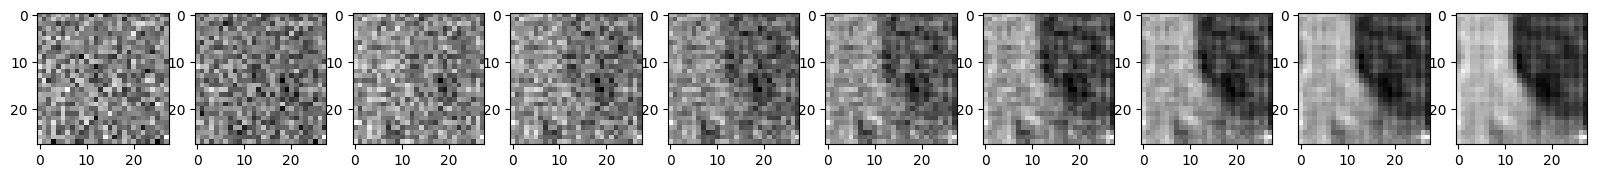

In [63]:
# Code for the plotting of samples goes here
shape =(1,1,32,32)
samples = sample(model, shape)


fig, axs = plt.subplots(nrows=1, ncols = 10)
fig.set_figwidth(20)
for i, idx in enumerate(range(0, T, stepsize)):
    a = samples[idx]
    a = CenterCrop((28,28))(a)
    axs[i].imshow(a.squeeze(), cmap="gray")


In [29]:
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  63298685


SimpleUnet(
  (relu): ReLU()
  (time_embedding): SinusoidalPositionEmbeddings()
  (time_lin): Linear(in_features=300, out_features=300, bias=True)
  (initial_proj): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=300, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=300, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform):

Include your best generated samples below. 

tensor([[[[81.8527, 79.4378, 81.1159,  ..., 76.9180, 79.2404, 76.9723],
          [79.1362, 80.9038, 81.2034,  ..., 79.4991, 81.2245, 77.5676],
          [80.6866, 81.2978, 81.7694,  ..., 79.7696, 80.7908, 77.5824],
          ...,
          [81.2078, 83.7740, 83.6340,  ..., 82.7842, 82.3373, 78.0791],
          [81.4320, 82.8922, 84.5913,  ..., 82.2868, 82.4815, 77.1750],
          [77.8279, 78.9217, 79.2838,  ..., 75.8978, 74.4394, 73.7049]]]])


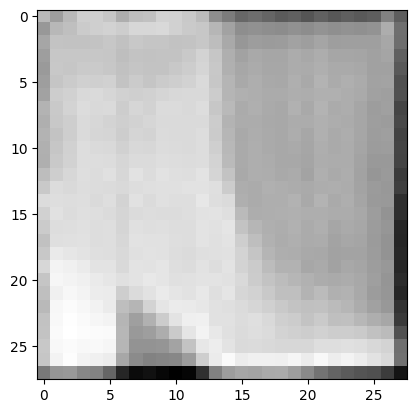

In [44]:
# Code to show the best samples goes here
a = samples[299]
print(a)
a = Resize((28,28))(a).squeeze()
plt.imshow(a,cmap = "gray")

Include your most efficient implementation details below. 

In [21]:
# Code to make your most efficient setup goes here; present all code from above in one Code block
# run it to show final runtimes and print out the total number of parameters in the mode. 




Interpretation of your results goes here. 

In [22]:
# Here goes the code for visualising during training and add a discussion above. 

### Part 3. On DeepDream [5 points]

In this task we will implement a DeepDream model in order to generate ‘dreams’: images enhanced by the neural network. 

Here we will work with a pre-trained model (Inception-V3). The idea is as follows: we will load some image (you can later on choose to load your own image if you want). We will load the Inception-V3 model. We will pass it an input and obtain the activation outputs from a certain layer. We will 'ask' the neural network to maximise the values of the activation, i.e. enhance the image with what those layer activations 'like' to see. For this we will implement a gradient ascent method in order to maximise a norm of the activations over that input. This will change our input into a `dream'. 

1. [1 point] Write a piece of code that will load the Inception-V3 model and allow you to get access to the intermediate activations. 

2. [2 points] Implement the deepdream optimisation loop. We will use gradient ascent to optimise for the norm of the activation. Implement a function that performs this gradient ascent. This function will take as input the number of iterations to perform, the learning rate, and the start image (i.e. the image which the model will enhance). Define in the function a for loop over the number of iterations, obtain the model output, get the output of the hook (hint: use something like `outputs[-1]`), compute the loss which will be L2 norm of this output (i.e. the L2 norm of the activations from your chosen layer), compute the gradients of this L2 norm loss, scale the gradients by their absolute average (hint: scale using `torch.abs(g).mean()`) and define a gradient ascent step over the image. Do not forget to zero out gradients where needed. 

3. [1 point] Implement code to load an image (e.g. https://github.com/pytorch/hub/raw/master/images/dog.jpg) and display the output from your optimisation loop (using e.g. numpy). Present the generated images for different choices of layer activations and different number of optimisation steps. Discuss your results. What is the impact of using different layers? What is the impact of the number of optimisation steps? [0.5 point will be given for the implementation and 1.5 point for a very good discussion]

4. [1 point] In our previous setting we allowed for optimising for a single layer's activation. Change the method such that it will allow to compute the loss (L2 norm) of multiple layers' outputs. Present three different setups using different numbers & combinations of layers and discuss your results in max. 3 lines. 

In [23]:
# YOUR ANSWERS GO HERE